# Tutorial 1 – Vocal Activity Detection

The high-level goal of **vocal activity detection** (VAD) is to identify whether or not an audio excerpt contains human vocalizations. As described in the article, this is hard for a few reasons:

* Other instruments take on vocal characteristics or functions, e.g. the melody
* Vocals are often louder in recorded music, which makes for an easy property to exploit without *really* doing the task

This notebook covers the basic steps of getting up and running with detecting vocal activity in recorded music. In this example, you will download a dataset, compute time-varying features, train a few machine learning models, evaluate them on a test set, and visualize time-varying outputs.

### Contents
0. [Getting the Data](#Getting-the-Data)
1. [Feature Extraction](#Feature-Extraction)
2. [Data Sampling](#Data-Sampling)
3. [Baseline Machine Learning](#Baseline-Machine-Learning)
4. [Modeling Longer Timescales](#Modeling-Longer-Timescales)
5. [Summary](#Summary)

In [1]:
# All libraries used in this notebook
import glob, keras, librosa, os, pescador, sklearn, tqdm

from IPython.display import Audio, display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
import soundfile as sf

%matplotlib inline

Using TensorFlow backend.


## Getting the Data

In this notebook, we use a subset of the OpenMIC-2018 collection, made publicly available via on Zenodo. These tracks are pulled from the Free Music Archive, and licensed under Creative Commons:

[OpenMIC-2018 dataset](https://zenodo.org/record/1432913)

The dataset is provided as a TGZ archive. Download and extract it to a location on disk; we'll refer to this as the dataset root, or `DATA_ROOT` below. Before running the following cell, update the path to where you've extracted the dataset.

The archive contains two important parts for this tutorial: a folder of audio files (`audio`) and a CSV file of item-instrument labels (`openmic-2018-aggregated-labels.csv`). Additionally, the source licenses are provided in an additional table (`openmic-2018-metadata.csv`). 

In [2]:
# Configure paths for the expected datasets
DATA_ROOT = '/Users/ejhumphrey/data/openmic-2018/'
AUDIO = os.path.join(DATA_ROOT, 'audio')
LABEL_FILE = os.path.join(DATA_ROOT, 'openmic-2018-aggregated-labels.csv')

# We'll write feature data here
FEATURES = os.path.join(DATA_ROOT, 'features')

if not os.path.exists(FEATURES):
    os.makedirs(FEATURES)

## Filtering to the Voice Subset

The OpenMIC collection was compiled for estimating multiple instruments from music recordings, but here, we only need to focus on whether or not a clip contains voice. 

To simplify things, we'll slice out the clips that have been annotated for `voice`.

In [3]:
df = pd.read_csv(LABEL_FILE, index_col=0)
df_voice = df[df.instrument == 'voice']
df_voice.sample(5)

,instrument,relevance,num_responses
sample_key,,,
104950_195840,voice,0.0,3
024258_88320,voice,1.0,3
036466_134400,voice,1.0,3
121479_42240,voice,1.0,3
131327_134400,voice,0.0,3


In [4]:
(df_voice.relevance > 0.5).sum(), (df_voice.relevance <= 0.5).sum()

(994, 582)

In this collection, `relevance` values greater than 0.5 correspond to a positive label (contains voice), and vice versa. Here, we see that there are nearly twice as many positive examples as negatives. Therefore a classifier that guessed `True` all the time would already be over 60% accurate. 

Each sample is 10 second of audio, drawn from a longer music recording. We'll dig into that more shortly.

## Feature Extraction

For these examples, we'll use mel-frequency cepstral coefficients (MFCCs) from `librosa`. 

**Why MFCCs?**

* Physiologically inspired – features are motivated by properties of the voice
* Speed – low-dimensional, reducing computational complexity and runtime
* Practicality – they tend to work okay in practice

Note that they are certainly not the best possible feature; as a result, feature design and audio representations are left as an area of exploration for the curious reader.

In [5]:
# Build filepaths for the voice-annotated samples.
audio_files = [os.path.join(AUDIO, i[:3], '{}.ogg'.format(i)) 
               for i in df_voice.index]

# Make sure that all audio files exist in the right place!
assert all([os.path.exists(fn) for fn in audio_files])

### Precompute features

We'll compute MFCCs in a batch process before worrying about modeling and evaluation. This will speed up computation later, since we'll only need to do this once here. In the following code, feature files that already exist are skipped by default.

In [6]:
def compute_mfccs(af, n_fft, hop_length, n_mfcc, skip_existing=True):
    sample_key = os.path.splitext(os.path.basename(af))[0]
    output_file = os.path.join(FEATURES, '{}.npz'.format(sample_key))
    if os.path.exists(output_file) and skip_existing:
        return
        
    y, sr = sf.read(af)        
    if y.ndim == 2:
        y = y.mean(axis=1)
    
    # Transpose to be time-major (rows)
    X = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, 
                             n_fft=n_fft, hop_length=hop_length).T

    time = librosa.frames_to_time(frames=np.arange(len(X)), 
                                  hop_length=hop_length, n_fft=n_fft, sr=sr)
        
    np.savez(output_file, mfcc=X, time=time)


In [7]:
# Compute MFCCs and write to disk. 
# In a single threaded MacBook Air, takes ≈2min
hop_length = 512
n_fft = 1024
n_mfcc = 20

for af in tqdm.tqdm_notebook(audio_files):
    compute_mfccs(af, n_fft, hop_length, n_mfcc)

In [8]:
# Now, let's pick up NPZ files on disk
feature_files = [os.path.join(FEATURES, '{}.npz'.format(i)) 
                 for i in df_voice.index]

# Also make sure that all feature files exist in the right place!
assert all([os.path.exists(fn) for fn in feature_files])

In [9]:
# Let's take a look at MFCCs for a given sample
row_idx = 25
row = df_voice.iloc[row_idx]
with np.load(feature_files[row_idx]) as data:
    feats = data['mfcc']
    time = data['time']

audio_file = audio_files[row_idx]
info = sf.info(audio_file)

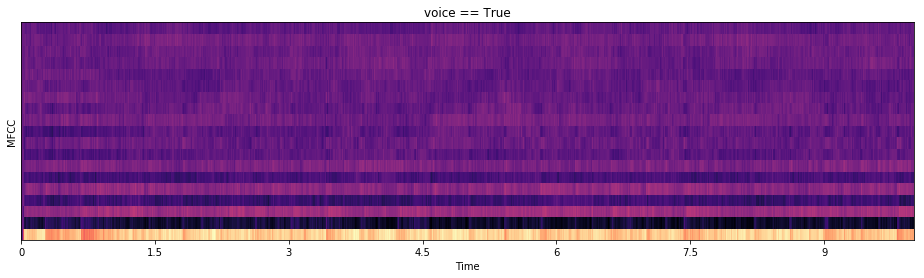

In [10]:
# Display the features against the reference annotation
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# Drop the first coefficient (amplitude) for visualization
librosa.display.specshow(feats.T[1:], sr=info.samplerate, hop_length=hop_length, 
                         x_axis='time', y_axis='off', ax=ax, cmap='magma')
ax.set_ylabel('MFCC')
ax.set_title('voice == {}'.format(row.relevance > 0.5))

display(Audio(filename=audio_file))

To this point, we have pre-computed time-varying MFCCs over the set of audio files with vocal annotations and wrote those features to disk in a Python friendly format.

Going forward, we'll drop the first MFCC (index 0), which roughly corresponds to loudness, because we'd prefer that our detection algorithm is invariant this dimension. Alternatively, we could *standardize* each coefficient (over time) by subtracting the mean and dividing by its standard deviation. It would be more technically correct to take the empirical measurements over *all* observed signals, to better approximate global statistics. Feature normalization presents a number of opportunities for system variation, and this is also left as an area of exploration.

## Data Sampling

Music audio presents interesting challenges in processing and manipulation. Audio signals are time-varying, and recordings are often minutes in length. While this can be computationally prohibitive to process holistically, you may want to make a prediction over a smaller time-frame, e.g. on the order of seconds.

A common approach is to sample "windowed" short-time observations, analogous to cropping small patches or regions out of an image. Here, we define sampling "generators" that are able to produce randomly drawn windows from a given file. This provides an added benefit of shuffling the observations drawn a potentially massive (i.e. doesn't fit in memory) dataset.

**Note:** You may be unfamiliar with generators, but they're really handy for stochastic sampling! Think of a generator like a stateful function that can continually produce samples from a "bag" of data, while keeping track of its progress. Through successive calls with `next`, or iterating over a generator, you can sample small windows from larger data efficiently.

### An audio sampler

First, here's an example generator that yields clips of listenable audio and the corresponding label.

In [11]:
def audio_sampler(row, clip_duration, random_state=None):
    '''Extract random audio clips with its vocal / non-vocal label.
    
    Parameters
    ----------
    row : pd.Series
        A row from the dataset.
        
    clip_duration : float
        Time (in sec) of the clip to produce
    
    random_state : int, or None
        Object to see the random number generator.
        
    Yields
    ------
    audio : np.ndarray, shape=(n,)
        Vector of audio samples
        
    label : bool
        True if the source clip contains voice.
    '''
    audio_file = os.path.join(AUDIO, row.name[:3], '{}.ogg'.format(row.name)) 
    x, sr = sf.read(audio_file)
    if x.ndim == 2:
        x = x.mean(axis=1)
        
    # Return the time intervals and labels of the VAD annotation
    duration = len(x) / sr
    window_size = int(0.5 + clip_duration * sr)
    rng = np.random.RandomState(random_state)
    
    while True:
        # Pick a random time in the waveform
        time_idx = rng.uniform(0, duration)
        
        # Test if a point in time falls in a labeled interval
        label = row.relevance > 0.5
        
        sample_idx = int(0.5 + time_idx * sr)
        i0 = max([0, sample_idx - window_size // 2])
        i1 = min([len(x), i0 + window_size])
        yield x[i0:i1], label
        

In [12]:
gen = audio_sampler(df_voice.sample(1).iloc[0], 3.0)
x, y = next(gen)
print('Contains voice: {}'.format(y))
Audio(data=x, rate=sf.info(audio_files[0]).samplerate)

Contains voice: False


Note that some of the audio samples produced may seem mislabeled; this is because the annotation applies to the full 10 second clip.

### An MFCC sampler

Now, we do something similar, but by pulling out patches of feature coefficients, computed previously.

The corresponding label for the frame is set as the "last" (or right-aligned) frame. This is consistent with experience, where the previous context is set-up for the instantaneous perception, tagged at the end.

In [13]:
def mfcc_sampler(row, num_frames, random_state=None):
    '''Sample a windowed feature observation.
    
    Parameters
    ----------
    row : pd.Series
        A row from the dataset.
    
    num_frames : int
        Number of frames to include in the observation
    
    random_state : int, or None
        Object to see the random number generator.
        
    Yields
    ------
    mfcc : np.ndarray, shape=(num_frames, n_mffc)
        Patch of time-varying MFCCs.
        
    label : int
        True/1 if the source clip contains voice.
    
    origin_key : str
        Key indicating where this patch was drawn from.
    '''
    
    npz_file = os.path.join(FEATURES, '{}.npz'.format(row.name))
    with np.load(npz_file) as data:
        mfcc = np.array(data['mfcc'])
        time = np.array(data['time'])
    
    idx = np.arange(num_frames, len(mfcc))

    rng = np.random.RandomState(random_state)
    rng.shuffle(idx)
    counter = 0
    label = row.relevance > 0.5
    while True:
        origin_key = '{}_{}'.format(row.name, int(0.5 + time[idx[counter]] * 1000))
        i1 = idx[counter]
        i0 = i1 - num_frames
        yield mfcc[i0:i1, :], label, origin_key

        counter += 1
        if counter == len(idx):
            counter = 0
            rng.shuffle(idx)

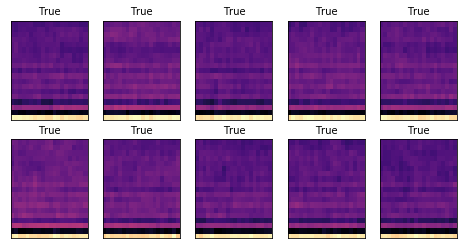

In [14]:
# Let's take a look at a few samples.
gen = mfcc_sampler(df_voice.sample(1).iloc[0], 20)
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)

for ax, (x, y, k) in zip(axes.flatten(), gen):
    librosa.display.specshow(x.T[1:], sr=44100, hop_length=hop_length, 
                             x_axis='off', y_axis='off', ax=ax, cmap='magma')
    ax.set_title(y, fontsize=10)

### Sampling data points for machine learning

To use machine learning to tackle VAD, we need to build both a labeled training and test (holdout) set. We do this here by splitting the collection into two parts, and sampling observations and the corresponding activity labels across different recordings.

In [15]:
# Split our collection into a set for training and test
num_files = len(df_voice)
full_idx = np.random.permutation(num_files)
num_train = int(0.5 + num_files * 0.75)
df_train, df_test = df_voice.iloc[full_idx[:num_train]], df_voice.iloc[full_idx[num_train:]]

First, we'll sample a feature vector from one frame. This corresponds to the information contained in the initial analysis window used to compute the MFCCs (`n_fft`, above).

In [16]:
num_frames = 1
num_train_samples = 100000

train_stream = pescador.ShuffledMux(
    [pescador.Streamer(mfcc_sampler, row, num_frames) 
     for _, row in df_train.iterrows()])

X_train, Y_train, K_train = [], [], []
for x, y, k in tqdm.tqdm_notebook(train_stream.iterate(max_iter=num_train_samples)):
    X_train += [x]
    Y_train += [y]
    K_train += [k]

X_train = np.array(X_train).squeeze()
print('Train - X: {}  Y: {}'.format(X_train.shape, len(Y_train)))


Train - X: (100000, 20)  Y: 100000


In [17]:
num_test_samples = 10000

test_stream = pescador.ShuffledMux(
    [pescador.Streamer(mfcc_sampler, row, num_frames)
     for _, row in df_test.iterrows()])

X_test, Y_test, K_test = [], [], []
for x, y, k in tqdm.tqdm_notebook(test_stream.iterate(max_iter=num_test_samples)):
    X_test += [x]
    Y_test += [y]
    K_test += [k]

X_test = np.array(X_test).squeeze()
print('Test - X: {}  Y: {}'.format(X_test.shape, len(Y_test)))


Test - X: (10000, 20)  Y: 10000


## Baseline Machine Learning

Here, we initialize two simple classifiers from `sklearn`, a Python library featuring a number of battle-tested machine learning models. 

In [18]:
# Define a few baseline classifiers
clfs = [
    sklearn.linear_model.LogisticRegressionCV(verbose=True, max_iter=500, 
                                              cv=3, multi_class='multinomial', n_jobs=-1),
    sklearn.ensemble.RandomForestClassifier(n_estimators=10)
]

# Note that this may take a minute or two
for clf in clfs: 
    clf.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.2s finished


In [19]:
# Compute accuracy metrics
print('   Train  Test')
for name, clf in zip(['LR', 'RF'], clfs): 
    print('{} {:0.3f} {:0.3f}'
          .format(name, clf.score(X_train, Y_train), 
                  clf.score(X_test, Y_test)))
    
print('\nBias: {:0.3f} {:0.3f}'
      .format(np.array(Y_train).mean(), np.array(Y_test).mean()))

   Train  Test
LR 0.779 0.768
RF 0.995 0.763

Bias: 0.638 0.607


So far, we've fit two simple ML models to our training set, and observed a few things:

* Logistic regression isn't able to model the data perfectly, but the mismatch in performance between train and test is pretty close. We take this to mean the logistic model doesn't have much capacity to model the data; and, the data we have isn't linearlly seperable. 
* The Random Forest model is overfitting the training set, but it generalizes roughly as well as the Logistic model (probably within statistical significance). We could try to regularize the Random Forest model to control the degree of overfitting, which may aid in generalization, or take on more variance in our data to make the modeling problem more challenging.
* Neither model performs *that* great. Both are only 15% (or so) better than random based on the label bias, e.g. if the model had guessed `True` for all samples.

## Modeling Longer Timescales

Based on these observations, and the fact that it's quite hard to recognize voice in a few hundred milliseconds, we'll now look at features sampled from several adjacent *frames*, known as a time-frequency **window**. 

### First-order Summary Statistics 

One of the more traditional approaches to modeling longer time-scales is to compute *summary statistics* over temporal windows, e.g. mean and standard deviation per coefficient. 

In [20]:
def statistics_sampler(row, num_frames, random_state=None):
    '''Sample statistics over a windowed feature observation, ordered as follows:
        X = [mean, std, min, max]
    
    Parameters
    ----------
    row : pd.Series
        A row from the dataset.
    
    num_frames : int
        Number of frames to include in the observation
    
    random_state : int, or None
        Object to see the random number generator.
        
    Yields
    ------
    features : np.ndarray, shape=(n_mffc * 4)
        Patch of MFCC coefficient statistics.
        
    label : int
        True/1 if the source clip contains voice.
    
    origin_key : str
        Key indicating where this patch was drawn from.
    '''
    
    npz_file = os.path.join(FEATURES, '{}.npz'.format(row.name))
    with np.load(npz_file) as data:
        mfcc = np.array(data['mfcc'])
        time = np.array(data['time'])
    
    idx = np.arange(num_frames, len(mfcc))

    rng = np.random.RandomState(random_state)
    rng.shuffle(idx)
    counter = 0
    label = row.relevance > 0.5
    while True:
        origin_key = '{}_{}'.format(row.name, int(0.5 + time[idx[counter]] * 1000))
        i1 = idx[counter]
        i0 = i1 - num_frames
        feats = np.array([fx(mfcc[i0:i1, :], axis=0) 
                          for fx in (np.mean, np.std, np.min, np.max)])
        yield feats.flatten(), label, origin_key

        counter += 1
        if counter == len(idx):
            counter = 0
            rng.shuffle(idx)

In [21]:
num_frames = 32
num_train_samples = 100000

train_stream = pescador.ShuffledMux(
    [pescador.Streamer(statistics_sampler, row, num_frames) 
     for _, row in df_train.iterrows()])

X_train, Y_train = [], []
for x, y, k in tqdm.tqdm_notebook(train_stream.iterate(max_iter=num_train_samples)):
    X_train += [x]
    Y_train += [y]

X_train = np.array(X_train).squeeze()
print('Train - X: {}  Y: {}'.format(X_train.shape, len(Y_train)))


Train - X: (100000, 80)  Y: 100000


In [22]:
num_test_samples = 10000

test_stream = pescador.ShuffledMux(
    [pescador.Streamer(statistics_sampler, row, num_frames)
     for _, row in df_test.iterrows()])

X_test, Y_test = [], []
for x, y, k in tqdm.tqdm_notebook(test_stream.iterate(max_iter=num_test_samples)):
    X_test += [x]
    Y_test += [y]

X_test = np.array(X_test).squeeze()
print('Test - X: {}  Y: {}'.format(X_test.shape, len(Y_test)))


Test - X: (10000, 80)  Y: 10000


In [23]:
# Use the same classifiers as before
clfs = [
    sklearn.linear_model.LogisticRegressionCV(verbose=True, max_iter=500, 
                                              cv=3, multi_class='multinomial', n_jobs=-1),
    sklearn.ensemble.RandomForestClassifier(n_estimators=10)
]

# Note that this takes around 2min
for clf in clfs: 
    clf.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.7min finished
/Users/ejhumphrey/miniconda3/envs/py36_spotify/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [24]:
# Compute accuracy metrics
print('   Train  Test')
for name, clf in zip(['LR', 'RF'], clfs): 
    print('{} {:0.3f} {:0.3f}'
          .format(name, clf.score(X_train, Y_train), 
                  clf.score(X_test, Y_test)))
    
print('\nBias: {:0.3f} {:0.3f}'
      .format(np.array(Y_train).mean(), np.array(Y_test).mean()))

   Train  Test
LR 0.818 0.805
RF 0.999 0.812

Bias: 0.637 0.610


Good news! The additional information provided by longer time-scales leads to better generalization in the test set, resulting in a performance improvement of a few percentage points.

Using summary statistics to describe longer patches of time is somewhat coarse, unfortunately. There are an infinite number of observations that don't come from anything we would call "music", yet would be represented by the same statistics. 

Next, we'll look into modeling the time-varying features directly.

### Sequence Models

Here, we return the the mfcc_sampler and attempt to model the time-varying MFCC sequence directly. Deep learning, made user friendly via `keras`, offers two operations that will come in handy: convolution and recurrence.

In [25]:
num_frames = 32
num_train_samples = 100000

train_stream = pescador.ShuffledMux(
    [pescador.Streamer(mfcc_sampler, row, num_frames) 
     for _, row in df_train.iterrows()])

X_train, Y_train = [], []
for x, y, k in tqdm.tqdm_notebook(train_stream.iterate(max_iter=num_train_samples)):
    X_train += [x]
    Y_train += [y]

X_train, Y_train = np.array(X_train), np.array(Y_train)
print('Train - X: {}  Y: {}'.format(X_train.shape, Y_train.shape))


Train - X: (100000, 32, 20)  Y: (100000,)


In [26]:
num_test_samples = 10000

test_stream = pescador.ShuffledMux(
    [pescador.Streamer(mfcc_sampler, row, num_frames) 
     for _, row in df_test.iterrows()])

X_test, Y_test = [], []
for x, y, k in tqdm.tqdm_notebook(test_stream.iterate(max_iter=num_test_samples)):
    X_test += [x]
    Y_test += [y]

X_test, Y_test = np.array(X_test), np.array(Y_test)
print('Test - X: {}  Y: {}'.format(X_test.shape, Y_test.shape))


Test - X: (10000, 32, 20)  Y: (10000,)


Note that the shape of the sampled data is now three-dimensional, representing `(sample, time, coefficient)`. 

### Fitting a temporal model

Previously, two machine learning models were fit to features that represented a summary of the full observation. Now, we'd like to leverage the fact that the coefficients vary over time, relative to each other, to fit a model that can exploit this multi-dimensional signal. 

To do this, we use a **convolutional neural network** (CNN), which convolves a number of smaller filters over the time-dimension, stacked hierarchically, with a final Dense (fully connected) layer at the output to act as a two-way classifier (False and True). While a full explanation of CNNs is beyond the scope of this tutorial, this particular *architecture* is inspired by Yann LeCun's seminal 1998 work (dubbed *LeNet*), and is standard in many deep learning tutorials.

In [28]:
x_in = keras.layers.InputLayer(input_shape=(32, 20))

bn0 = keras.layers.BatchNormalization(axis=-1, scale=True)
layer0 = keras.layers.Conv1D(filters=15, kernel_size=5, 
                             padding='valid', activation='relu')
pool0 = keras.layers.MaxPool1D(pool_size=2)

bn1 = keras.layers.BatchNormalization(axis=-1, scale=True)
layer1 = keras.layers.Conv1D(filters=30, kernel_size=5, 
                             padding='valid', activation='relu')
pool1 = keras.layers.MaxPool1D(pool_size=2)
flat = keras.layers.Flatten()

drop2 = keras.layers.Dropout(rate=0.5)
layer2 = keras.layers.Dense(units=100, activation='relu')

drop3 = keras.layers.Dropout(rate=0.5)
layer3 = keras.layers.Dense(units=2, activation='softmax')

dnn = keras.Sequential([x_in, bn0, layer0, pool0, 
                        bn1, layer1, pool1, flat,
                        drop2, layer2, drop3, layer3])
dnn.compile('Adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 32, 20)            80        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 15)            1515      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 15)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 15)            60        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 30)            2280      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 30)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150)               0         
__________

Now we'll train the model for several iterations through the dataset, referred to as an *epoch*. You are welcome to let this run as long as you'd like, but be careful of overfitting!

**Keep in mind**, it's worth nothing that "deep learning" models can't be optimized directly, and so training tends to be more intuition driven than principled, for better or worse. Here, we only step through a few epochs in the spirit of timeliness - this won't result in the best possible performance, but will demonstrate that the model has learned something of value in a few minutes.

In [29]:
# This will run for ≈3 min
history = dnn.fit(X_train, Y_train, epochs=10)

Epoch 1/10
100000/100000 [==============================] - 18s 184us/step - loss: 0.4452 - acc: 0.8023
Epoch 2/10
100000/100000 [==============================] - 28s 280us/step - loss: 0.3974 - acc: 0.8255
Epoch 3/10
100000/100000 [==============================] - 22s 216us/step - loss: 0.3798 - acc: 0.8337
Epoch 4/10
100000/100000 [==============================] - 20s 198us/step - loss: 0.3649 - acc: 0.8414
Epoch 5/10
100000/100000 [==============================] - 23s 227us/step - loss: 0.3586 - acc: 0.8442
Epoch 6/10
100000/100000 [==============================] - 21s 214us/step - loss: 0.3528 - acc: 0.8466
Epoch 7/10
100000/100000 [==============================] - 23s 231us/step - loss: 0.3459 - acc: 0.8493
Epoch 8/10
100000/100000 [==============================] - 22s 222us/step - loss: 0.3405 - acc: 0.8523
Epoch 9/10
100000/100000 [==============================] - 21s 207us/step - loss: 0.3349 - acc: 0.8562
Epoch 10/10
100000/100000 [==============================] - 22s

In [30]:
print('Train Accuracy', (dnn.predict_classes(X_train) == Y_train).mean())
print('Test Accuracy', (dnn.predict_classes(X_test) == Y_test).mean())

Train Accuracy 0.88416
Test Accuracy 0.8173


### Visualizing the outputs

Now we'll inspect the predictions of the model over a full recording. To do this, we have to "slide" (or convolve) the model over a longer feature sequence.

Note that a recurrent model *could* be applied to arbitrary length inputs, which would make full track prediction easier – however, we haven't trained the model to behave well in these conditions, and leave it as an exercise for the reader. 

/Users/ejhumphrey/data/openmic-2018/features/023005_7680.npz
/Users/ejhumphrey/data/openmic-2018/audio/023/023005_7680.ogg


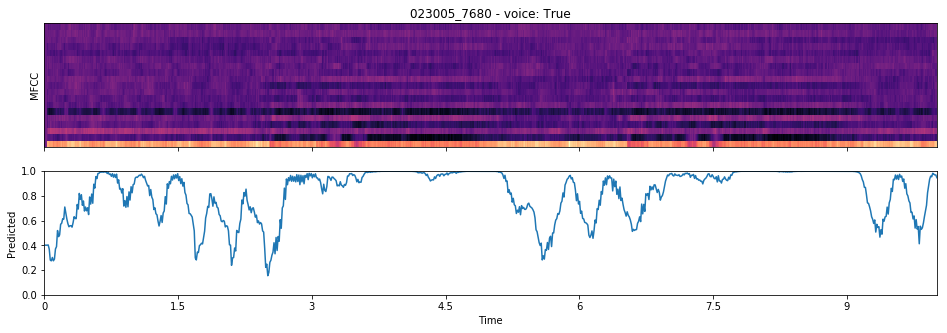

In [31]:
# Let's take a look at MFCCs vs a reference annotation vs the predicted likelihood
row = df_train.sample(n=1).iloc[0]

npz_file = os.path.join(FEATURES, '{}.npz'.format(row.name))
print(npz_file)
with np.load(npz_file) as data:
    mfcc = np.array(data['mfcc'])
    time = data['time']

audio_file = os.path.join(AUDIO, row.name[:3], '{}.ogg'.format(row.name)) 
print(audio_file)
info = sf.info(audio_file)

# Pad the time-varying features the length of the observation
# We need to do this to produce an equal-length output as the `time` array.
mfcc = np.pad(mfcc, ((num_frames, 0), (0, 0)), 'edge')
Y_pred = dnn.predict(np.array([mfcc[n:n + num_frames] 
                               for n in range(len(time))]))

# Display the features against the reference annotation
fig, axes = plt.subplots(2, 1, figsize=(16, 5), sharex=True)

# Drop the first coefficient (amplitude) for visualization
librosa.display.specshow(mfcc.T[1:, num_frames:], 
                         sr=info.samplerate, hop_length=hop_length, 
                         x_axis='time', y_axis='off', ax=axes[0], cmap='magma')
axes[0].set_ylabel("MFCC")
axes[1].plot(time, Y_pred[:, 1])
axes[1].set_ylabel("Predicted")
axes[1].set_ylim(0, 1)

# Display tweaks
for ax, xlabel, title in zip(axes, ['', 'Time'], 
                             ['{} - voice: {}'.format(row.name, row.relevance > 0.5), '']):
    ax.set_xlabel(xlabel)
    ax.set_title(title)

display(Audio(filename=audio_file))
# print('Overall Accuracy: {:.3f}'
#       .format((labels == Y_pred.argmax(axis=1)).mean()))

## Summary

In this notebook, we've covered a number of basics in modeling vocal signals:

* Extracted MFCC features
* Defined sample generators that yield windowed observations with labels from the data
* Sampled a large collection into a training and test set to fit our models
* Fit a few different machine learning models
* Explored two approaches to modeling time
* Computed accuracy / error over the train/test partitions
* Applied a trained model over features to produce a time-varying vocal likelihood

## Where to go next?

We've only begun to scratch the surface of singing voice modeling! This demonstration is by no means intended to illustrate the state of the art, but rather a place from which to start a more interesting exploration. With that in mind, here are a few next steps for those who would like to dive deeper into vocal activity detection.

### 1. Different Features

We've used MFCCs here because they're small (20 coefficients) and are motivated by vocal properties, but it's likely that there exists a more optimal acoustic representations that would lead to better performance. Different time-frequency representations, such as a Constant-Q filterbank or short-time Fourier Magnitude coefficients may preserve more information.

### 2. Model Variations

We've used a few straightforward modeling approaches, but the neural networks used here could be deeper, wider, trained for many more epochs, employ any number of training tricks, e.g. dropout, be optimized over longer sequences ... you get the idea. There's a huge space of opportunity to explore around modeling innovations.

### 3. Comprehensive Evaluation

We've subsampled the data to speed things up, but these models should be evaluated with all available data. A thorough evaluation would compute accuracy across all tracks, averaged over all time and normalized per track (micro and macro statistics). For example, you may want to identify which track in the test set the model performs worst on. Additionally, per the discussion in the article, it would be worth evaluating these models with instrumental data, or by varying the loudness or equalization of test audio.